##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](./images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](./images/gan2.png)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [2]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf

In [4]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\pmegh\appdata\local\temp\pip-req-build-zl5cnh1x
  Resolved https://github.com/tensorflow/docs to commit 70174a87eb9c39b6f71d948801e140e9436e66e8
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\pmegh\AppData\Local\Temp\pip-req-build-zl5cnh1x'


In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import cv2
from tqdm import tqdm
import numpy as np


train_image_path = './chest_xray/train'
img_path = []
img_label = []
img_folder = os.listdir(train_image_path)
for x in img_folder:
    path = os.path.join(train_image_path, x)
    file_path = os.listdir(path)
    for y in file_path:
        source_path = os.path.join(path, y)
        img_path.append(source_path)
        img_label.append(x)

# Concatenate data paths with labels into one dataframe
df = pd.DataFrame(img_path, columns= ['image_path'])
df['label']= img_label

# Assuming you have a DataFrame named df with columns 'image_path' and 'label'
# Example DataFrame:
# df = pd.DataFrame({'image_path': ['path/to/image1.jpg', 'path/to/image2.jpg'],
#                    'label': [0, 1]})

# Create a function to load and preprocess your dataset
def load_custom_dataset():
    # Create empty lists to store images and labels
    images = []
    labels = []

    # Iterate through each row in the DataFrame
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Loading Images"):
        # Read the image using OpenCV
        image_path = row['image_path']
        label = row['label']
        
        img = cv2.imread(image_path)  # Use cv2.imread for OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

        # Optional: You might want to resize the images to a specific size
        img = cv2.resize(img, (28, 28))
        img = img.reshape(28,28,1)

        # Print the shape of the image for debugging
        # print(f"Original image shape: {img.shape}")
        # Append the image and label to the respective lists
        images.append(img)
        labels.append(label)

    # Return images and labels as a tuple
    return images, labels


# Create a tf.data.Dataset using the loaded images and labels
def create_tfds_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

# Load and preprocess your custom dataset
images, labels = load_custom_dataset()

# Create a tf.data.Dataset
custom_dataset = create_tfds_dataset(images, labels)


import numpy as np

images = []
labels = []
for image, label in custom_dataset:
  images.append(np.squeeze(image.numpy()))
  labels.append(label.numpy().decode('utf-8'))

images = np.expand_dims(images, -1)

train_images = images
train_labels = labels

Loading Images: 100%|█████████████████████████████████████████████████████████████| 3883/3883 [00:22<00:00, 172.85it/s]


In [8]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [9]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def dataset_to_numpy(dataset):
    images = []
    for batch in dataset:
        images.append(batch.numpy())
    return np.vstack(images)

# Convert the TensorFlow dataset to a NumPy array
dataset_array = dataset_to_numpy(train_dataset)

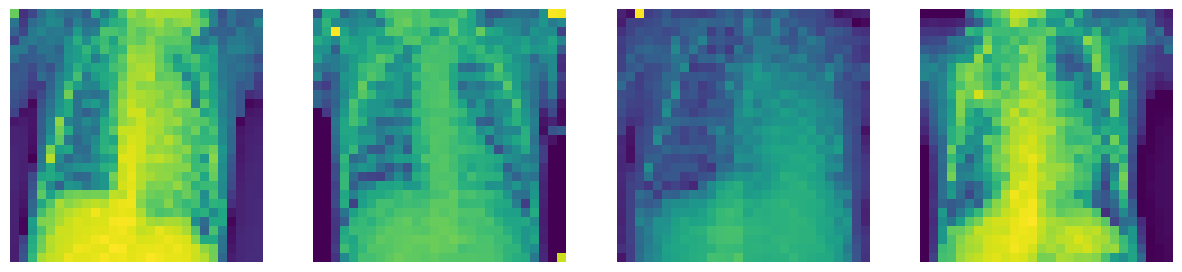

In [13]:
def plot_images(images, rows, columns):
    fig, axs = plt.subplots(rows, columns, figsize=(15, 5))
    axs = axs.flatten()
    
    for i in range(rows * columns):
        axs[i].imshow(images[i])
        axs[i].axis('off')
    
    plt.show()

# Plot images with 1 row and 4 columns
plot_images(dataset_array[:4], rows=1, columns=4)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

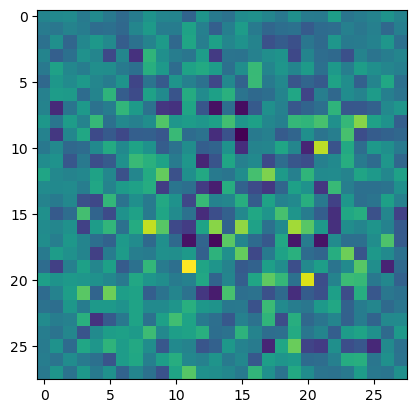

In [15]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
  
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [17]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [21]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [23]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
g_loss=[]
d_loss=[]

In [25]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    tf.py_function(g_loss.append, [gen_loss], [])
    tf.py_function(d_loss.append, [disc_loss], [])

In [26]:
def train(dataset, epochs):
  
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed) 

**Generate and save images**

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

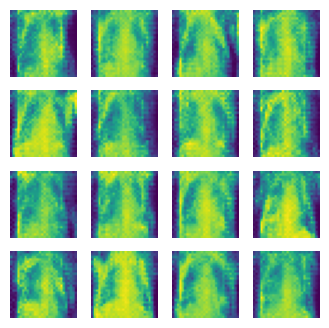

In [28]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [29]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [30]:
d_loss_values = [tensor.numpy() for tensor in d_loss]

# Now, d_loss_values is a list of numerical values
# print(len(d_loss_values))
# d_loss_values

In [31]:
g_loss_values = [tensor.numpy() for tensor in g_loss]

# Now, d_loss_values is a list of numerical values
# print(len(g_loss_values))
# g_loss_values

## Create metrics viz



In [32]:
# import matplotlib.pyplot as plt

# # ... (existing code)

# # Plot generator and discriminator losses
# plt.plot(range(1, len(g_loss_values)+1), g_loss_values, label='Generator Loss')
# plt.plot(range(1, len(d_loss_values)+1), d_loss_values, label='Discriminator Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


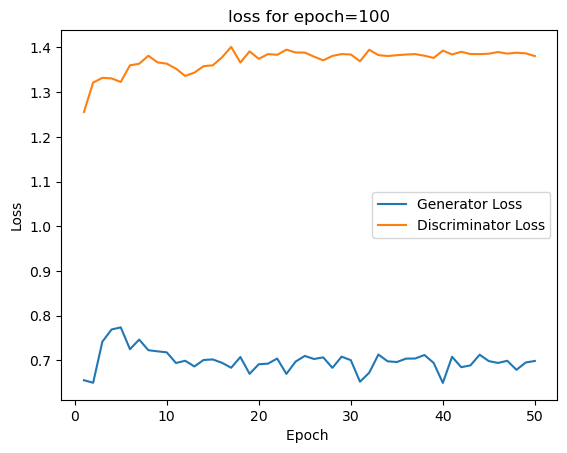

In [33]:
g_loss = np.array(g_loss)
d_loss = np.array(d_loss)

# Calculate the mean for every 16 values
g_loss_means = [np.mean(g_loss[i:i+16]) for i in range(0, len(g_loss), 16)]
d_loss_means = [np.mean(d_loss[i:i+16]) for i in range(0, len(d_loss), 16)]

# Plot the means

plt.title('loss for epoch=100')
plt.plot(range(1, len(g_loss_means)+1), g_loss_means, label='Generator Loss ')
plt.plot(range(1, len(d_loss_means)+1), d_loss_means, label='Discriminator Loss')
plt.xlabel('Epoch ')
plt.ylabel('Loss')
plt.legend()
plt.show()

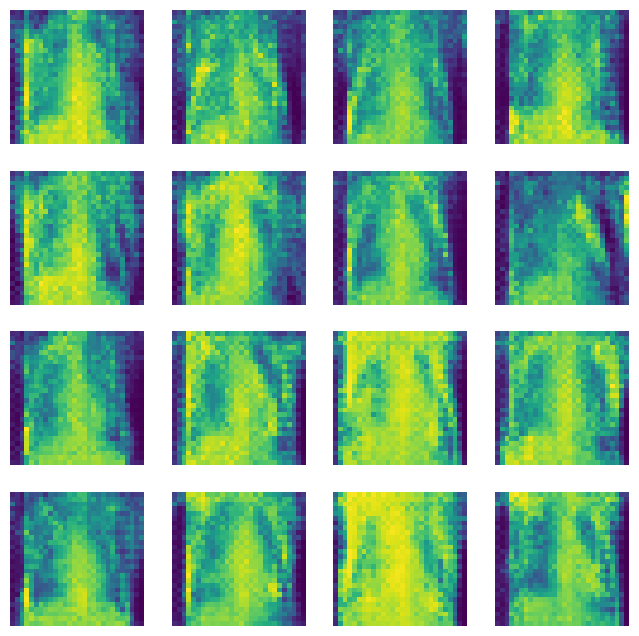

In [34]:
noise = tf.random.normal([16, 100])  # Generate 16 samples
generated_images = generator(noise, training=False)

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[i * 4 + j, :, :, 0] * 127.5 + 127.5)
        axs[i, j].axis('off')

plt.show()

In [35]:
# generator.save('generator_model.h5')
# discriminator.save('discriminator_model.h5')

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.stats import entropy

# Load InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

def generate_synthetic_images(generator, num_samples):
    noise = tf.random.normal([num_samples, noise_dim])
    synthetic_images = generator(noise, training=False)

    # Duplicate the single-channel image along the third axis to have three color channels
    synthetic_images = tf.concat([synthetic_images] * 3, axis=-1)

    return synthetic_images  # Add this line to return the generated synthetic images
# Function to calculate Inception Score
def calculate_inception_score(generator, num_samples=500, batch_size=50):
    # Generate synthetic images using the generator
    synthetic_images = generate_synthetic_images(generator, num_samples)

    # Resize and preprocess images for InceptionV3
    resized_images = preprocess_input(tf.image.resize(synthetic_images, (299, 299), method=tf.image.ResizeMethod.BICUBIC))

    # Calculate Inception Score
    inception_score = compute_inception_score(resized_images, batch_size)
    
    return inception_score

# Function to compute Inception Score
def compute_inception_score(images, batch_size):
    # Create batches of images
    batches = [images[i:i + batch_size] for i in range(0, len(images), batch_size)]

    # Get predictions from the InceptionV3 model for each batch
    predictions = []
    for batch in batches:
        batch_predictions = inception_model.predict(batch)
        predictions.append(batch_predictions)

    # Flatten the predictions
    predictions = np.concatenate(predictions, axis=0)

    # Compute the marginal distribution (mean) of predictions
    p_yx = np.mean(predictions, axis=0)

    # Compute the Inception Score using KL Divergence
    kl_divergence = entropy(predictions.T, qk=np.tile(p_yx, (predictions.shape[0], 1)).T)
    inception_score = np.exp(np.mean(kl_divergence))

    return inception_score



# Example usage in your existing code
# Call this function after training your GAN model
inception_score = calculate_inception_score(generator, num_samples=500)
print("Inception Score:", inception_score)


2/2 [==============================] - 3s 1s/step
Inception Score: 1.0073618


In [37]:
# Inception Score: 1.0008662 : epoch = 50